In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import pairwise
from IPython.display import HTML
import extract_feature_vector
from IPython.display import Image as iImage
import base64
from PIL import Image
from io import BytesIO
import topfivebreeds
import matplotlib.pyplot as plt
import seaborn as sns
import math
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

/Users/miaCDIPS/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pd.set_option('display.max_colwidth', -1)


In [28]:
def maketop10df(top10list):
    simpetsdf = pd.DataFrame(columns=['Picture','Pet Name','Breeds','Shelter/Location/Contact','Similarity\\nScore'])
    for simpic in top10list.index:    
        petid,picnum = simpic.split('_')
        filestr = pfdf.loc[petid,'media'][int(picnum)-1][0]
        imgstr = '''<img style="border:3px solid white" src="'''+filestr+'''">'''
        simpetsdf.loc[simpic,'Picture'] = imgstr
        simpetsdf.loc[simpic,'Pet Name'] = pfdf.loc[petid,'petname']
        if pfdf.loc[petid,'breed2']:
            simpetsdf.loc[simpic,'Breeds'] = ',\\n'.join([pfdf.loc[petid,'breed1'],pfdf.loc[petid,'breed2']])
        else:
            simpetsdf.loc[simpic,'Breeds'] = pfdf.loc[petid,'breed1']
        infodict={}
        for info in ['email','city','state','zip', 'country', 'sheltername' ]:
            if pfdf.notnull().loc[petid,info]:
                infodict[info]=pfdf.loc[petid,info]  
            else:
                infodict[info] = ''
        simpetsdf.loc[simpic,'Shelter/Location/Contact'] = str(infodict['sheltername'] + '\\n'
                                                       + infodict['city']+', '
                                                       + infodict['state'] + ' ' 
                                                       + infodict['zip'] + ' '  
                                                       + infodict['country'] + '\\n'
                                                       + infodict['email'])

        simpetsdf.loc[simpic,'Similarity\\nScore'] = "{0:.4f}".format(top10list.loc[simpic])
    return simpetsdf

In [2]:
PETPHOTOPATH='/Users/miaCDIPS/petphotos/'
TESTINPUTPATH = "/Users/miaCDIPS/Desktop/testpics/"

In [3]:
table_list = []
for i in range(1,31):
    table_list.append('pf_vectors_'+'0'*(3-math.floor(math.log10(i)))+str(i))

In [5]:
pfdf = pd.read_pickle('pfdf_clean.pkl')

In [19]:
pfdf.memory_usage(index=True,deep=True).sum()

92480334

# LET'S INPUT AN IMAGE HERE
Here, we have already trained our neural network, and input an image to obtain the model's prediction (which breed of dog), but more importantly, to extract the feature vector used to describe the image.

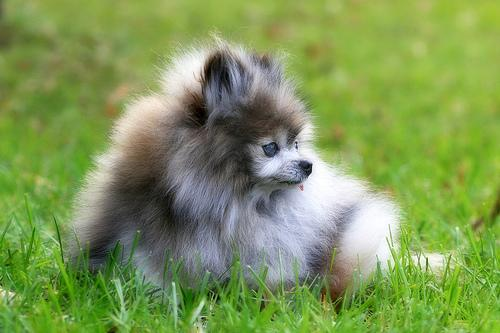

In [54]:
input_image_filepath = TESTINPUTPATH + "pom5.jpg"
inputimg = iImage(filename = input_image_filepath, height = 600)
display(inputimg)

## Our re-trained neural network can predict which breed:

In [55]:
breeds,scores = topfivebreeds.top5graph(input_image_filepath)

In [44]:
output_notebook()

Loading BokehJS ...

In [66]:
                empty=['']*5
                p = figure(y_range=breeds[::-1], plot_height=500,plot_width=685,title="Breed scores",toolbar_location=None, tools="")
                #p = figure(y_range=empty, plot_height=500,plot_width=500,title="Breed scores",toolbar_location=None, tools="")
                p.hbar(right = scores[::-1], y=breeds[::-1], height=0.9)
                #p.hbar(right = scores[::-1], y=empty,height=0.9)
                p.ygrid.grid_line_color = None
                p.x_range.start = 0
                p.xaxis.axis_label = 'Scores'
                p.axis.major_label_text_font_size = "14pt"


In [67]:
empty, breeds

(['', '', '', '', ''],
 ['pomeranian',
  'keeshond',
  'samoyed',
  'papillon',
  'shetland sheepdog sheltie'])

In [68]:
show(p)

/Users/miaCDIPS/anaconda3/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


## but even several categorical labels fail to capture the complexity of a dog's appearance.  Instead let's describe our dog with a 2048-dimensional feature _vector_...

## ...and compare against the other dogs in our image database.  
We measure the cosine similarity between our input and every other dog in our database, getting a similarity score for each.  Let's take a look at the 10 most similar.

In [36]:
%%time
input_vector = extract_feature_vector.run_inference_on_image(input_image_filepath)
similarities=pd.Series()
for table in table_list:
    df = pd.read_hdf('storage.h5',table)
    similarities=similarities.append(pd.Series(np.squeeze(pairwise.cosine_similarity(df,input_vector.reshape(1,-1))), index=df.index))
    del df    
simpetsdf = maketop10df(similarities.sort_values(ascending=False,kind='heapsort').head(10))


CPU times: user 13.2 s, sys: 7.14 s, total: 20.3 s
Wall time: 19.7 s


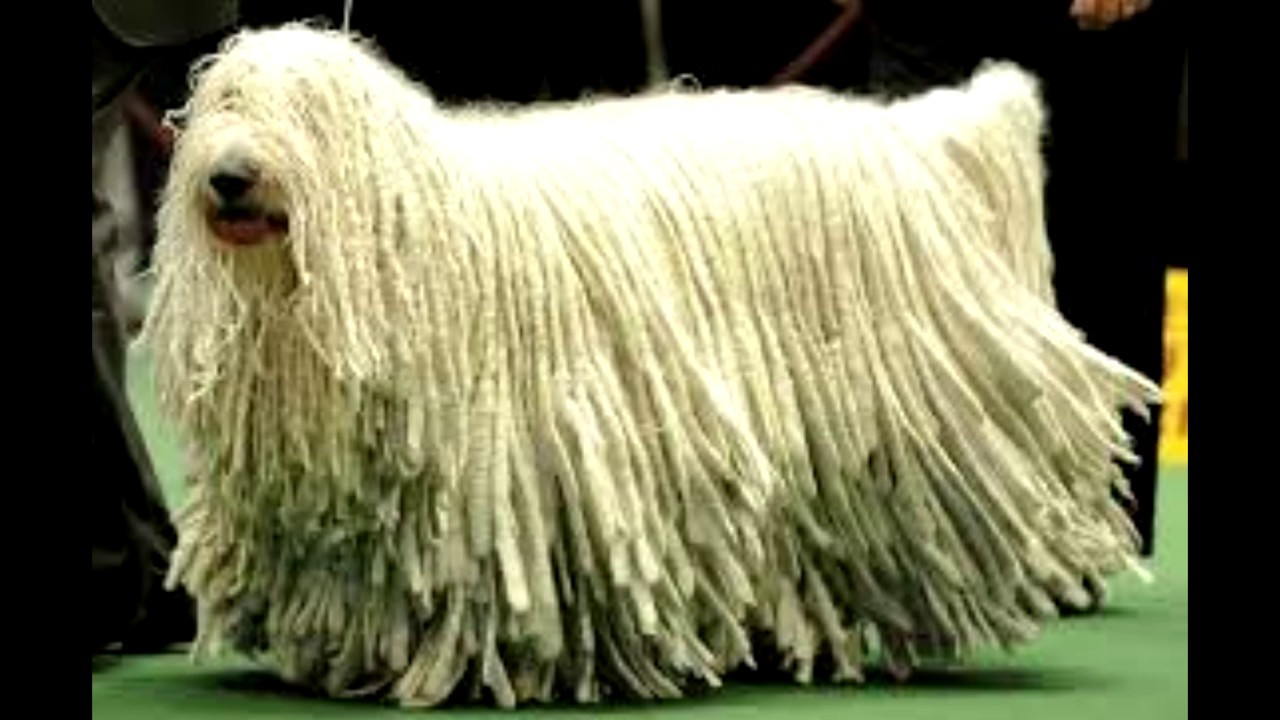

Picture,Pet Name,Breeds,Shelter/Location/Contact,SimilarityScore
,Lilo,Komondor,"Furever Tails Animal RescueOakland, MI 48363 USrescue@furevertails.com",0.7215
,Alex Shih Tzu,Shih Tzu,"Zanis Furry Friends ZFF, IncNew York, NY 10028 USinfo@zanisfurryfriends.org",0.7188
,Lilo,Komondor,"Furever Tails Animal RescueOakland, MI 48363 USrescue@furevertails.com",0.6880
,Z - In need of rescue!!,Old English Sheepdog,"SPCA of WestchesterBriarcliff Manor, NY 10510 USshelter@spca914.org",0.6384
,Mickey Pirate Maltix,"Maltese,West Highland White Terrier Westie","Zanis Furry Friends ZFF, IncNew York, NY 10028 USinfo@zanisfurryfriends.org",0.6277
,popcorn,"Maltese,Poodle","Shaggy Dog RescueHouston, TX 77006 USkathy@houstonshaggydogrescue.org",0.6274
,Alys,Poodle,"City of Denton Animal ServicesDenton, TX 76205 USdentonanimalservices@yahoo.com",0.6223
,Adopted!! Annie and Tia - IN,Bichon Frise,"Small Paws Rescue Inc.Indianapolis, IN 46201 USadoptionspf@smallpawsrescue.org",0.6187
,Adopted!! Tia and Annie - IN,Bichon Frise,"Small Paws Rescue Inc.Indianapolis, IN 46201 USadoptionspf@smallpawsrescue.org",0.6187
,Hayley,"Maltese,Poodle","Farfel's Farm & RescueBoulder, CO 80302 USfarfelsrescue@gmail.com",0.6072


In [37]:
display(inputimg)
style = "<style> td{font-size: 16px;}</style>"
HTML(style+simpetsdf.to_html(escape=False,index=False).replace('\\n','<br>'))